# Data Mining II Project 
***
#### University of Pisa - Federica Trevisan

# Time series
Given the 50+ years long history of stock values of a company, split it into years, and study their similarities, also using clustering.

## Dataset
IBM stocks (source: Yahoo Finance). Dataset obtained from Yahoo!Finance service.

## Objectives
Compare similarities, compute clustering.

In [98]:
import csv
import time
import numpy as np
import pandas as pd
from pandas import Grouper
from pandas import DataFrame
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from scipy.stats import itemfreq
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 20,5

Populating the interactive namespace from numpy and matplotlib


## Dataset: IBM stock values from 1962 to 2018

In [51]:
series = pd.Series.from_csv('ibm_daily_1962-2018.csv', sep='\t',header=0)

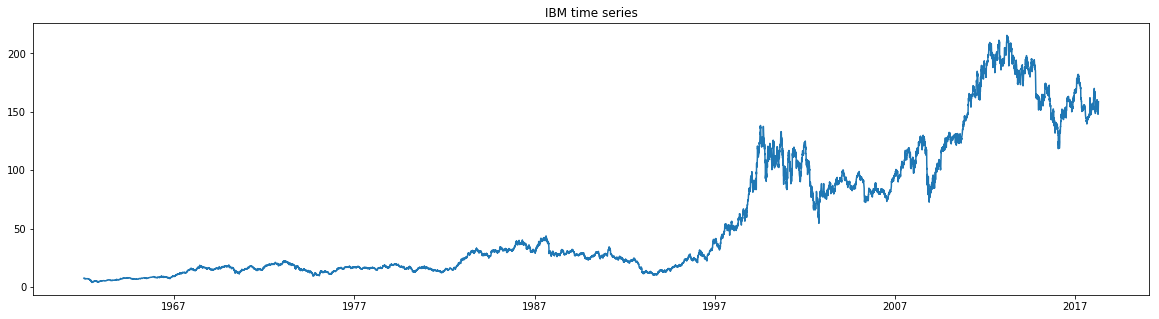

In [52]:
plot(series)
plt.title("IBM time series")
savefig('ts1.png')

In [53]:
len(series)

14168

## Split the time series into years (57 series)
and plot normalized time series

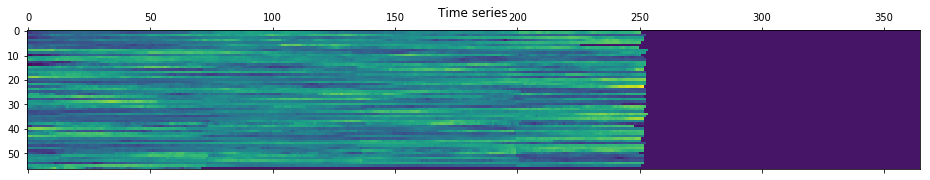

In [54]:
groups = series.groupby(pd.Grouper(freq='A')) #years

ts = DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_values,(0,365-len(norm_values)),'constant',constant_values=-3)
    ts["%s-%s" % (name.year,name.month)] = pad_values
matshow(ts.T, interpolation=None, aspect='auto')


plt.title("Time series")
savefig('ts2.png')

In [55]:
ts.describe()

,1962-12,1963-12,1964-12,1965-12,1966-12,1967-12,1968-12,1969-12,1970-12,1971-12,...,2009-12,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,-0.928767,-0.936986,-0.920548,-0.928767,-0.928767,-0.936986,-1.142466,-0.945205,-0.912329,-0.920548,...,-0.928767,-0.928767,-0.928767,-0.945205,-0.928767,-0.928767,-0.928767,-0.928767,-0.936986,-2.416438
std,1.619038,1.621076,1.616957,1.619038,1.619038,1.621076,1.657974,1.623069,1.614830,1.616957,...,1.619038,1.619038,1.619038,1.623069,1.619038,1.619038,1.619038,1.619038,1.621076,1.268491
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
50%,-0.751043,-0.731456,-0.822792,-0.713343,-0.661492,-0.608752,-1.116679,-0.851067,-0.786373,-0.751251,...,-0.661029,-0.631853,-0.644262,-0.618510,-0.785189,-0.089908,-0.824367,-0.248346,-0.648132,-3.000000
75%,0.252776,0.512918,0.628187,0.372810,0.319593,0.064606,0.273885,0.556417,0.439581,0.301487,...,0.655266,-0.162207,0.239229,0.319459,0.509015,0.536371,0.512553,0.453410,-0.094932,-3.000000
max,1.776867,1.903684,1.845674,2.049961,2.118249,2.099008,2.392273,1.790852,2.337387,1.969308,...,1.693461,2.136363,2.141775,2.093728,1.916541,1.390788,1.661469,1.575376,2.011699,2.348330


# Preparation

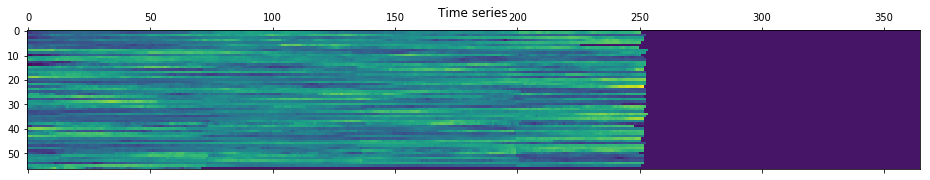

In [56]:
ts1 = DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_values,(0,365-len(norm_values)),'constant',constant_values=-3)
    ts1["%s" % (name.year)] = pad_values
matshow(ts1.T, interpolation=None, aspect='auto')

plt.title("Time series")
savefig('ts6.png')

In [57]:
#delete year 2018
ts2 = DataFrame()
ts2 = ts1
ts1.drop('2018',axis=1,inplace=True)

In [58]:
ts1

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.776867,-2.140522,-1.614994,-2.278684,-0.679659,-1.833692,-0.519033,-0.643405,1.866399,-0.242625,...,-0.064971,-1.802252,-0.069982,-2.199020,-1.403257,0.001766,0.435955,0.516034,-1.246023,0.767625
1,1.697297,-2.305218,-1.381504,-2.418447,-0.825006,-1.869509,-0.838566,-0.781846,1.907956,-0.420053,...,-0.321502,-1.619973,0.000962,-2.166298,-1.569369,0.143868,0.314398,0.512553,-1.147947,0.831488
2,1.758505,-1.884326,-1.573298,-2.390493,-0.843176,-1.926816,-1.116679,-0.989508,1.970293,-0.266282,...,-0.375768,-1.570261,-0.140925,-2.186867,-1.678204,0.010761,0.430669,0.373290,-1.349173,0.954236
3,1.678934,-1.884326,-1.564960,-2.246738,-0.752334,-1.855182,-1.382957,-1.220243,1.977219,-0.183482,...,-0.603932,-1.518387,-0.255854,-2.206499,-1.738349,-0.060291,0.363725,0.158304,-1.406667,0.907791
4,1.544275,-1.884326,-1.681704,-1.991172,-0.661492,-1.726241,-1.300115,-1.139486,1.984146,-0.266282,...,-0.616265,-1.519828,-0.369361,-2.051305,-2.051961,-0.103461,0.622693,0.074747,-1.450633,0.972483
5,1.452463,-1.646434,-1.481571,-1.783526,-0.670574,-1.611627,-1.211355,-0.989508,2.004924,-0.372739,...,-0.757480,-1.574583,-0.087007,-2.164428,-1.904463,-0.053096,0.595387,0.264492,-1.566465,0.848904
6,1.513671,-1.600684,-0.997910,-1.871376,-0.679659,-1.582973,-1.175852,-0.874140,1.991072,-0.443710,...,-0.780297,-1.753260,-0.375038,-2.106464,-2.262467,-0.127744,0.532847,0.314974,-1.410895,0.688834
7,1.532034,-1.536636,-0.847809,-1.839430,-0.688744,-1.511339,-1.022002,-1.162559,1.956441,-0.289939,...,-0.668681,-1.686256,-0.182072,-2.126097,-2.100649,0.007162,0.352274,0.163526,-1.423577,0.831488
8,1.599363,-1.490889,-0.747741,-1.783526,-0.688744,-1.539993,-0.874070,-1.335611,2.133060,-0.295853,...,-0.310402,-1.779917,-0.159369,-2.009233,-2.441469,-0.112454,0.246573,-0.045367,-1.556319,0.848075
9,1.623847,-1.252991,-0.497575,-1.655742,-0.643324,-1.511339,-0.732055,-0.943361,2.157303,-0.349082,...,-0.494167,-1.822425,0.050623,-2.041955,-2.315451,-0.248260,0.313518,0.113914,-1.718653,0.741915


In [59]:
l = list(ts1)
s = 0
x = 0
for i in l:
    x = (ts1[i] == -3.000000).sum()
    s = s + x
avg = s / len(l)
print("Average days with value = -3", avg)

('Average days with value = -3', 113)


In [60]:
ts1.drop(ts1.tail(113).index,inplace=True)

In [61]:
ts1

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.776867,-2.140522,-1.614994,-2.278684,-0.679659,-1.833692,-0.519033,-0.643405,1.866399,-0.242625,...,-0.064971,-1.802252,-0.069982,-2.199020,-1.403257,0.001766,0.435955,0.516034,-1.246023,0.767625
1,1.697297,-2.305218,-1.381504,-2.418447,-0.825006,-1.869509,-0.838566,-0.781846,1.907956,-0.420053,...,-0.321502,-1.619973,0.000962,-2.166298,-1.569369,0.143868,0.314398,0.512553,-1.147947,0.831488
2,1.758505,-1.884326,-1.573298,-2.390493,-0.843176,-1.926816,-1.116679,-0.989508,1.970293,-0.266282,...,-0.375768,-1.570261,-0.140925,-2.186867,-1.678204,0.010761,0.430669,0.373290,-1.349173,0.954236
3,1.678934,-1.884326,-1.564960,-2.246738,-0.752334,-1.855182,-1.382957,-1.220243,1.977219,-0.183482,...,-0.603932,-1.518387,-0.255854,-2.206499,-1.738349,-0.060291,0.363725,0.158304,-1.406667,0.907791
4,1.544275,-1.884326,-1.681704,-1.991172,-0.661492,-1.726241,-1.300115,-1.139486,1.984146,-0.266282,...,-0.616265,-1.519828,-0.369361,-2.051305,-2.051961,-0.103461,0.622693,0.074747,-1.450633,0.972483
5,1.452463,-1.646434,-1.481571,-1.783526,-0.670574,-1.611627,-1.211355,-0.989508,2.004924,-0.372739,...,-0.757480,-1.574583,-0.087007,-2.164428,-1.904463,-0.053096,0.595387,0.264492,-1.566465,0.848904
6,1.513671,-1.600684,-0.997910,-1.871376,-0.679659,-1.582973,-1.175852,-0.874140,1.991072,-0.443710,...,-0.780297,-1.753260,-0.375038,-2.106464,-2.262467,-0.127744,0.532847,0.314974,-1.410895,0.688834
7,1.532034,-1.536636,-0.847809,-1.839430,-0.688744,-1.511339,-1.022002,-1.162559,1.956441,-0.289939,...,-0.668681,-1.686256,-0.182072,-2.126097,-2.100649,0.007162,0.352274,0.163526,-1.423577,0.831488
8,1.599363,-1.490889,-0.747741,-1.783526,-0.688744,-1.539993,-0.874070,-1.335611,2.133060,-0.295853,...,-0.310402,-1.779917,-0.159369,-2.009233,-2.441469,-0.112454,0.246573,-0.045367,-1.556319,0.848075
9,1.623847,-1.252991,-0.497575,-1.655742,-0.643324,-1.511339,-0.732055,-0.943361,2.157303,-0.349082,...,-0.494167,-1.822425,0.050623,-2.041955,-2.315451,-0.248260,0.313518,0.113914,-1.718653,0.741915


#### Transformation I: Offset Translation

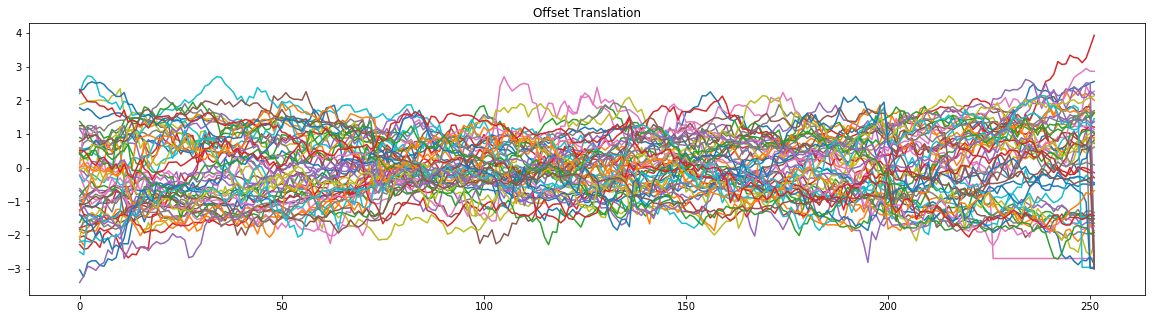

In [62]:
ts1 = ts1 - ts1.mean()
plot(ts1)

plt.title("Offset Translation")
savefig('ts3.png')

#### Transformation II: Amplitude Scaling

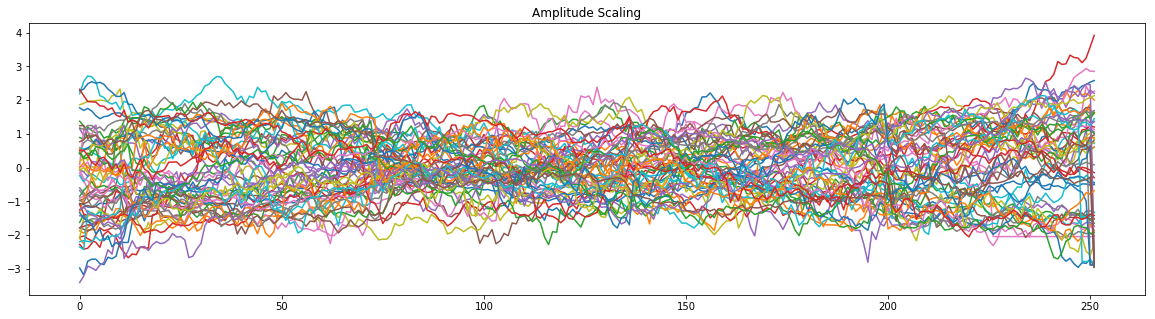

In [63]:
ts1 = ( ( ts1 - ts1.mean() ) / ts1.std() )
plot(ts1)

plt.title("Amplitude Scaling")
savefig('ts4.png')

#### Transformation IV: Noise (smoothing)

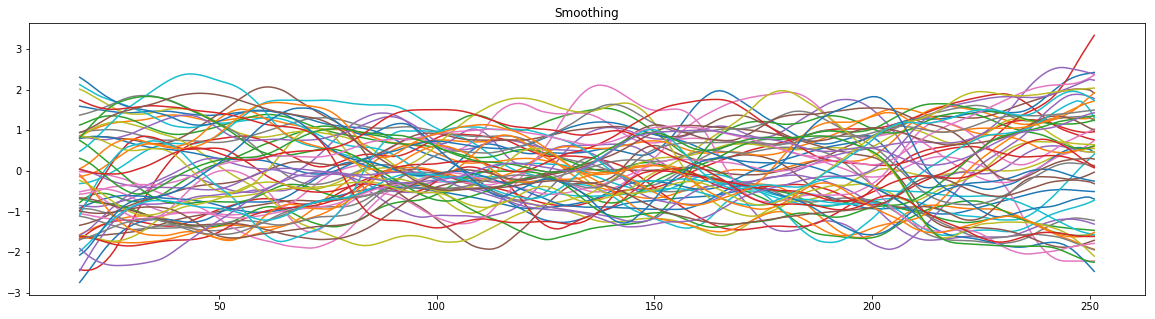

In [67]:
ts1 = ( (ts1 - ts1.mean()) / ts1.std() ).rolling(window=10).mean()
plot(ts1)

plt.title("Smoothing")
savefig('ts5.png')

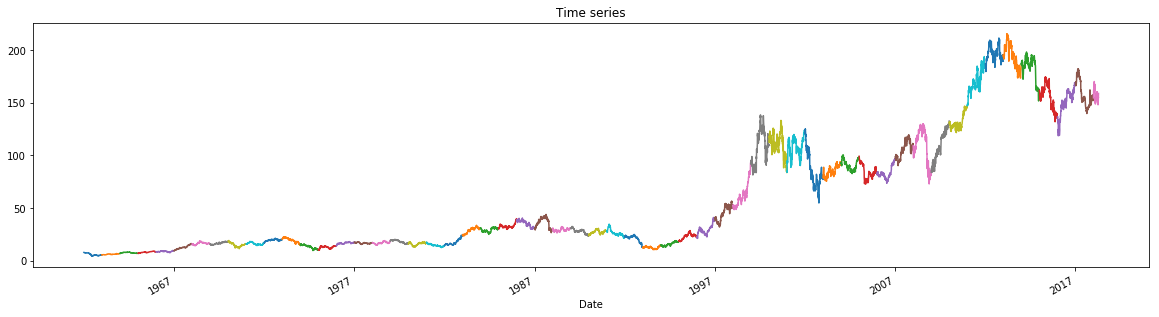

In [68]:
groups.plot()
plt.title("Time series")
savefig('ts7.png')

### Lag plot

C:\Users\feder\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


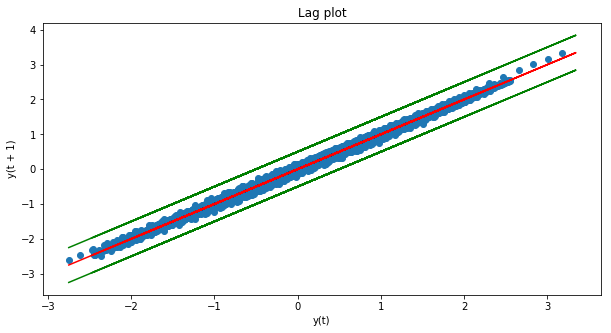

In [73]:
from pandas.tools.plotting import lag_plot
lag_plot( ts1 )
# Plot also some reference lines to highlight strong correlation areas
plot(ts1, ts1, 'r-')
plot(ts1, ts1+0.5, 'g-')
plot(ts1, ts1-0.5, 'g-')

rcParams['figure.figsize'] = 10,5

plt.title("Lag plot")
savefig('ts8.png')

C:\Users\feder\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


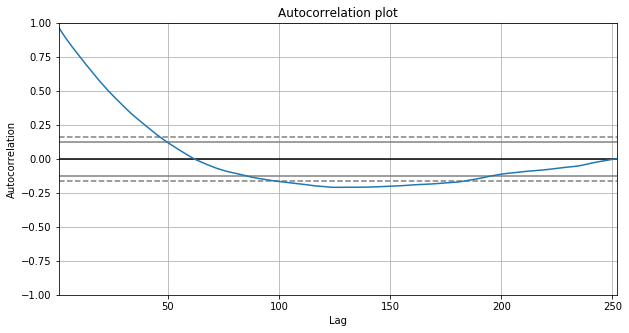

In [75]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(ts2)

rcParams['figure.figsize'] = 10,5
plt.title("Autocorrelation plot")
savefig('ts9.png')

# DTW

In [ ]:
month_list = mm1.keys()
# Compute upper half of matrix
dd1 = [ [ (dtw(mm1[month_list[x]],mm1[month_list[y]],distance)[0] \
           if y > x else -1)  
         for y in range(len(month_list)) ] 
     for x in range(len(month_list)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(month_list)) ] for x in range(len(month_list)) ]
# Finally, the diagonal
for i in range(len(month_list)):
    dd2[i][i] = 0.0

In [ ]:
csvfile = "years_distance_matrix_modded.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(dd2)

In [84]:
with open('years_distance_matrix_modded2222.csv', 'rb') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    distances = list(reader)
    years_list = ts.keys()

In [85]:
x = 0
y = 0
for i in range(0,len(distances)):
    x = max(distances[i])
    if (x > y):
        y = x
print y

431.348597298


### Plot the matrix of distances

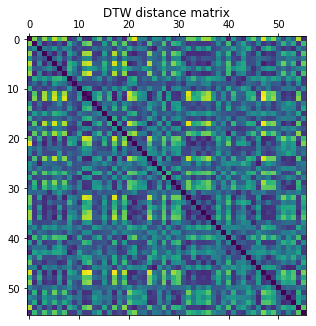

In [96]:
matshow(distances, interpolation=None, aspect='auto')

plt.title("DTW distance matrix")
savefig('ts10.png')

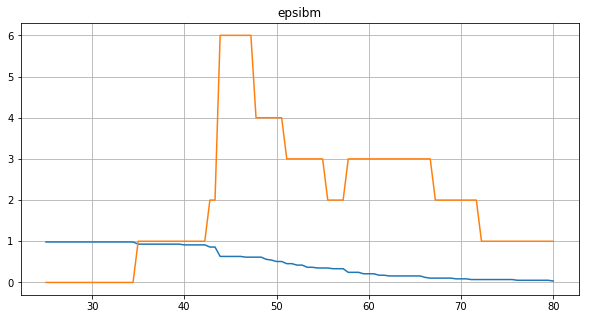

In [87]:
eps_list = linspace(25.0,80,num=100)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=3, metric='precomputed').fit(distances)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/57)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
pyplot.title("Number of clusters, noise and epsilon")
#plot([0.8,0.8],[0,5],'r-')

plt.title("eps")
savefig('ts9.png')

('Stress value: ', 1222759.6163045834)
0 	-->  ['1973', '1974']
-1 	-->  ['1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


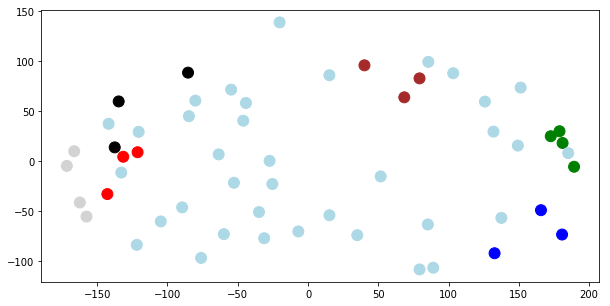

In [86]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(distances)
print ("Stress value: ", pos.stress_)

cols = ['blue','brown','black','lightgray', 'red', 'green', 'orange', 'lightblue']
l=0
cc = [ cols[l] for l in db.labels_]

years_list = ts1.keys()

# Assign colors based on clusters
db = DBSCAN(eps=33, min_samples=2, metric='precomputed').fit(distances)
fig,ax = plt.subplots()
plt.scatter(pos.embedding_.T[0], pos.embedding_.T[1], c=cc, s=120) 

cluster_sets = [ (l_,years_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print pp[0], "\t--> ", list(pp[1])

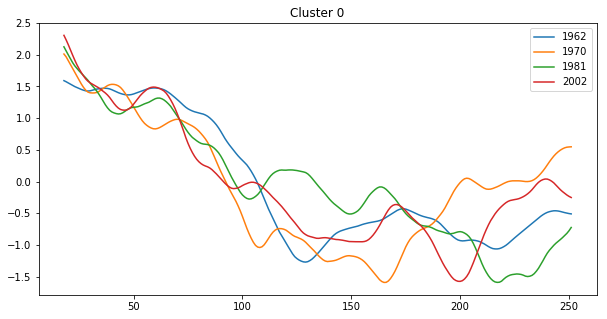

In [83]:
#cluster0
l = ['1962', '1970', '1981', '2002']
for i in l:
    plot(ts1[i])
plt.legend()
plt.title("Cluster 0")

plt.title("Cluster 0")
savefig('cluster0dtw.png')

Text(0.5,1,'Cluster 1')

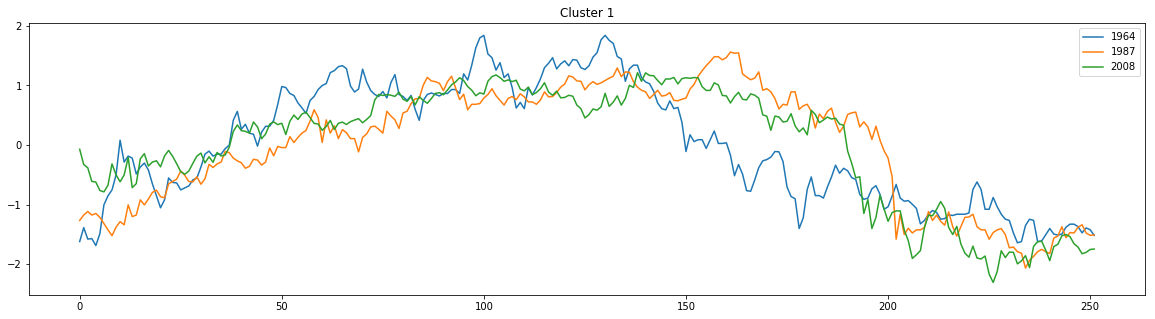

In [47]:
#cluster1 
l = ['1964', '1987', '2008']
for i in l:
    plot(ts1[i])
plt.legend()
plt.title("Cluster 1")

plt.title("Cluster 1")
savefig('cluster1dtw.png')

Text(0.5,1,'Cluster 2')

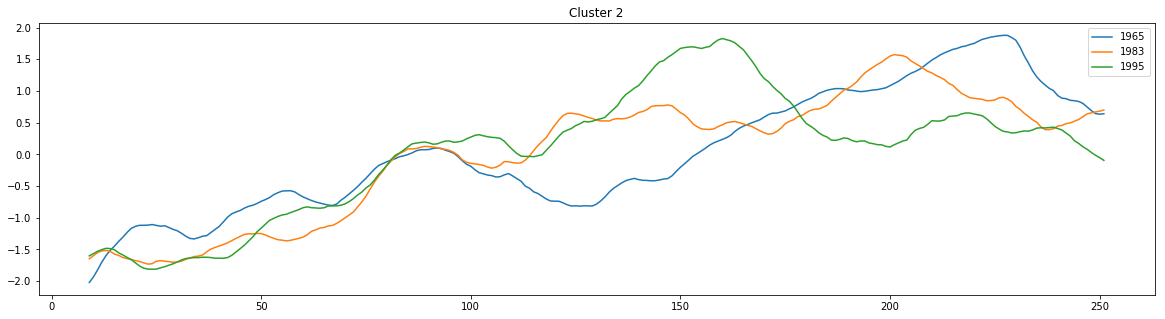

In [37]:
#cluster2
l =  ['1965', '1983', '1995']
for i in l:
    plot(mm1[i])
plt.legend()
plt.title("Cluster 2")

plt.title("Cluster 2")
savefig('cluster2dtw.png')

Text(0.5,1,'Cluster 3')

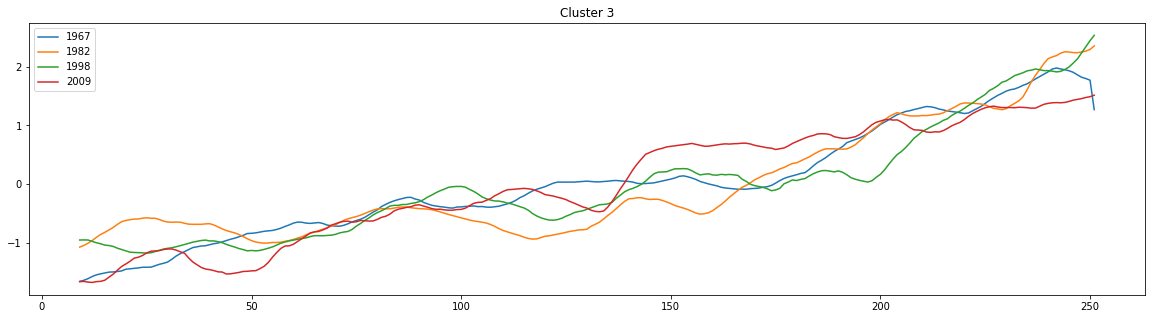

In [38]:
#cluster 3
l = ['1967', '1982', '1998', '2009']
for i in l:
    plot(mm1[i])
plt.legend()
plt.title("Cluster 3")


plt.title("Cluster 3")
savefig('cluster3dtw.png')

Text(0.5,1,'Cluster 4')

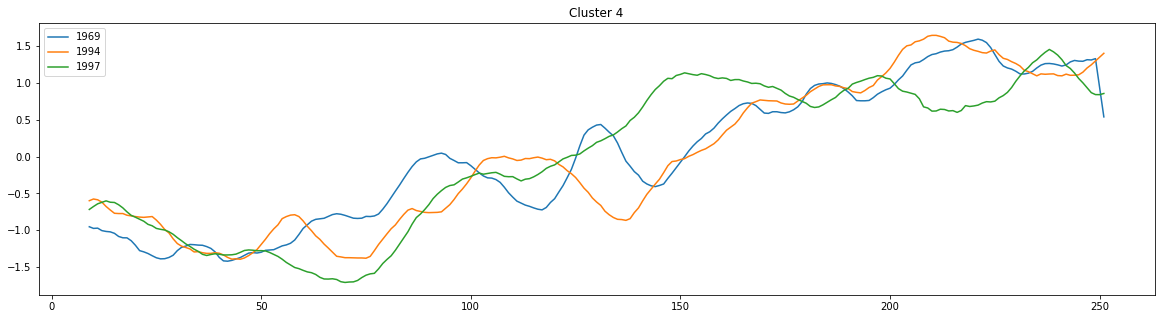

In [39]:
#cluster 4 
l = ['1969', '1994', '1997']
for i in l:
    plot(mm1[i])
    
plt.legend()
plt.title("Cluster 4")


plt.title("Cluster 4")
savefig('cluster4dtw.png')

Text(0.5,1,'Cluster 5')

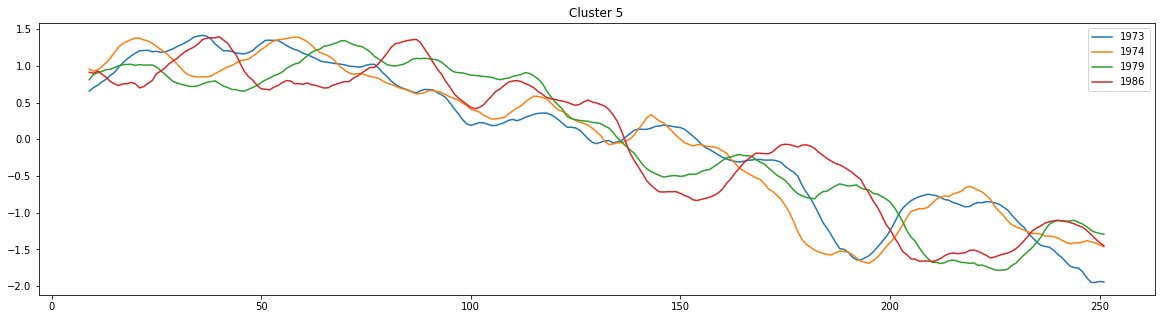

In [40]:
#cluster5
l =  ['1973', '1974', '1979', '1986']
for i in l:
    plot(mm1[i])
    
plt.legend()
plt.title("Cluster 5")


plt.title("Cluster 5")
savefig('cluster5dtw.png')

# Eucledian distance

In [100]:
#assicurarsi prima di aver fatto lo smoothing di mm1
ts1.dropna(inplace=True)

columns = list(ts1.columns)
#calcola matrice delle distanze euclidee
#D0 = D1 = matrix of point-to-point costs
D0 = zeros((len(columns) + 1, len(columns) + 1))
D0[0, 1:] = inf
D0[1:, 0] = inf
D1 = D0[1:, 1:] # view (hide first column and first row)

#Fill the point-to-point costs matrix
for i in range(0,len(columns)):
    for j in range(0,len(columns)):
        D1[i, j] = numpy.linalg.norm(ts1[columns[i]]- ts1[columns[j]])

D1


array([[ 0.        , 27.51803709, 19.79560359, ..., 17.43942252,
        28.008097  ,  7.78635914],
       [27.51803709,  0.        , 24.31414446, ..., 25.01728421,
        12.84353693, 27.36578563],
       [19.79560359, 24.31414446,  0.        , ...,  6.23709307,
        21.59472018, 20.15996404],
       ...,
       [17.43942252, 25.01728421,  6.23709307, ...,  0.        ,
        24.44507634, 18.31742799],
       [28.008097  , 12.84353693, 21.59472018, ..., 24.44507634,
         0.        , 28.61859171],
       [ 7.78635914, 27.36578563, 20.15996404, ..., 18.31742799,
        28.61859171,  0.        ]])

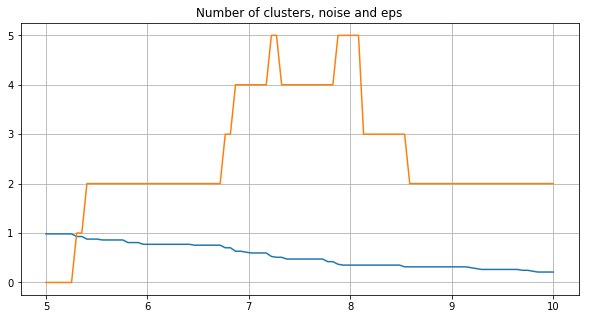

In [107]:
eps_list = linspace(5,10,num=100)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=3, metric='precomputed').fit(D1)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))

plot(eps_list, noise_list/57)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
rcParams['figure.figsize'] = 10,5
pyplot.title("Number of clusters, noise and eps")
#plot([0.8,0.8],[0,5],'r-')
savefig('epseucledian.png')

In [112]:
#guardando i valori di eps sopra si vede quale scegliere


ts1.dropna(inplace=True)
dbscanA = DBSCAN(eps=8, min_samples=2, metric='precomputed') 
dbscanA.fit(D1)
years_list = ts1.keys()
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscanA.labels_)) - (1 if -1 in dbscanA.labels_ else 0)

cluster_sets_euclid = [ (l_,years_list[dbscanA.labels_ == l_]) for l_ in set(dbscanA.labels_) ]
for pp in cluster_sets_euclid:
    print pp[0], "\t--> ", list(pp[1])

print('Number of clusters found: %d' % n_clusters_)


0 	-->  ['1962', '1970', '1991', '2002', '2004', '2017']
1 	-->  ['1963', '1965', '1967', '1969', '1978', '1982', '1983', '1994', '1996', '1997', '1998', '2003', '2006', '2007', '2009', '2010', '2011']
2 	-->  ['1964', '2015']
3 	-->  ['1972', '1995', '2016']
4 	-->  ['1973', '1974', '1979', '1981', '1986', '2013']
5 	-->  ['1987', '1992', '2008', '2014']
-1 	-->  ['1966', '1968', '1971', '1975', '1976', '1977', '1980', '1984', '1985', '1988', '1989', '1990', '1993', '1999', '2000', '2001', '2005', '2012']
Number of clusters found: 6


In [113]:
print itemfreq(dbscanA.labels_)
print(dbscanA.labels_)

[[-1 18]
 [ 0  6]
 [ 1 17]
 [ 2  2]
 [ 3  3]
 [ 4  6]
 [ 5  4]]
[ 0  1  2  1 -1  1 -1  1  0 -1  3  4  4 -1 -1 -1  1  4 -1  4  1  1 -1 -1
  4  5 -1 -1 -1  0  5 -1  1  3  1  1  1 -1 -1 -1  0  1  0 -1  1  1  5  1
  1  1 -1  4  5  2  3  0]


C:\Users\feder\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


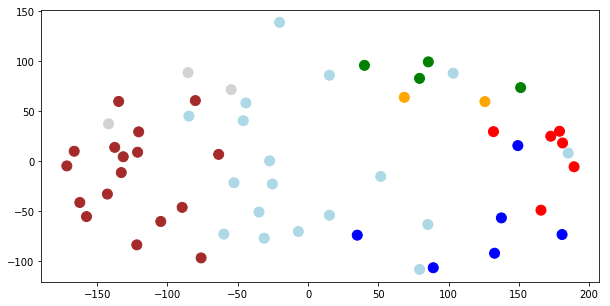

In [114]:
cols = ['blue','brown','orange','lightgray', 'red', 'green', 'black','lightblue']
cc = [ cols[l] for l in dbscanA.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], c=cc, s=100)

In [47]:
print("Clusters found using dbscan with euclidean distance")
for pp in cluster_sets_euclid:
    print pp[0], "\t--> ", list(pp[1])

print("Clusters found using dbscan with precomputed distances (dtw)")
for pp in cluster_sets:
    print pp[0], "\t--> ", list(pp[1])


Clusters found using dbscan with euclidean distance
0 	-->  ['1962', '2002']
1 	-->  ['1964', '2015']
2 	-->  ['1965', '1967', '1969', '1982', '1983', '1994', '1996', '1997', '1998', '2003', '2006', '2007', '2009', '2010', '2011']
3 	-->  ['1973', '1974', '1979', '1981', '1986', '2013']
4 	-->  ['1987', '1992', '2008', '2014']
5 	-->  ['1991', '2017']
-1 	-->  ['1963', '1966', '1968', '1970', '1971', '1972', '1975', '1976', '1977', '1978', '1980', '1984', '1985', '1988', '1989', '1990', '1993', '1995', '1999', '2000', '2001', '2004', '2005', '2012', '2016']
Clusters found using dbscan with precomputed distances (dtw)
0 	-->  ['1962', '1981', '2002']
1 	-->  ['1964', '1987', '2008']
2 	-->  ['1965', '1983', '1995']
3 	-->  ['1967', '1982', '1998', '2009']
4 	-->  ['1969', '1994', '1997']
5 	-->  ['1973', '1974', '1979', '1986']
-1 	-->  ['1963', '1966', '1968', '1970', '1971', '1972', '1975', '1976', '1977', '1978', '1980', '1984', '1985', '1988', '1989', '1990', '1991', '1992', '1993',

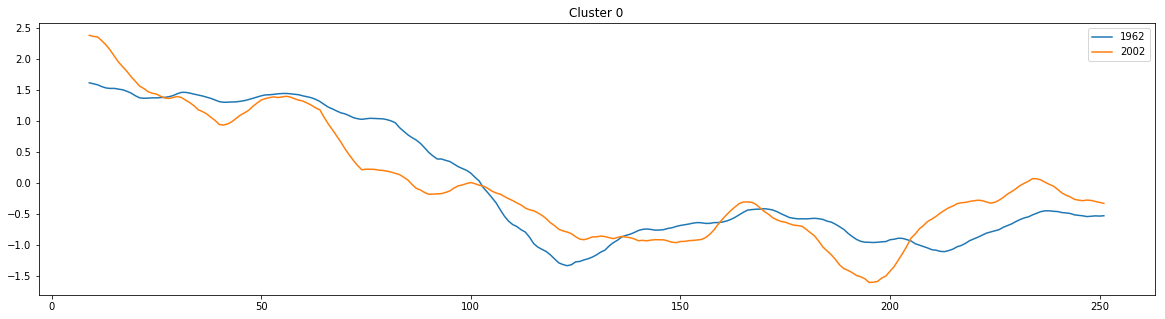

In [48]:
#cluster0
l = ['1962', '2002']
for i in l:
    plot(mm1[i])
plt.title("Cluster 0")
plt.legend()

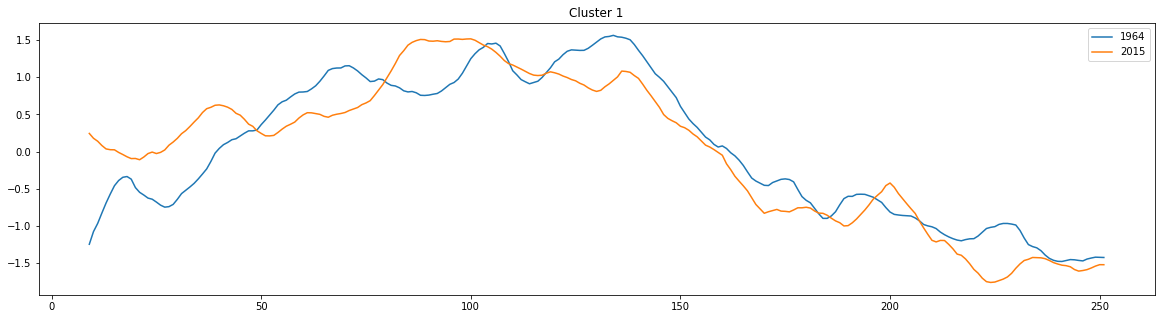

In [49]:
#cluster1
l = ['1964', '2015']
for i in l:
    plot(mm1[i])
plt.title("Cluster 1")
plt.legend()

Text(0.5,1,'Cluster 2')

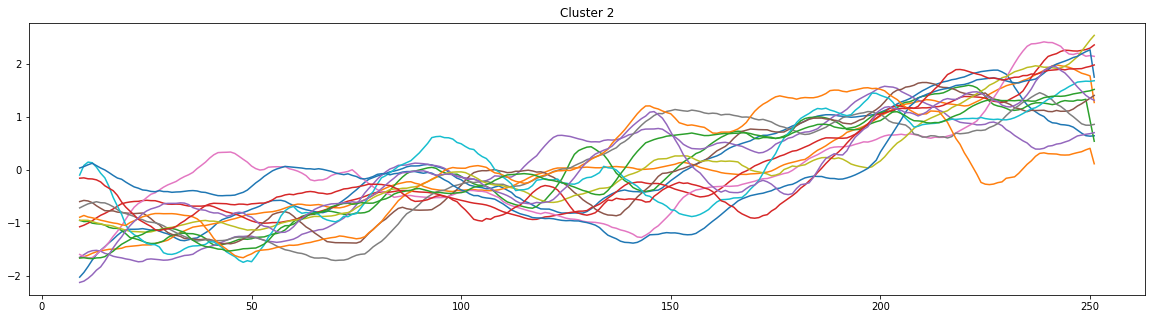

In [50]:
#cluster2
l=['1965', '1967', '1969', '1982', '1983', '1994', '1996', '1997', '1998', '2003', '2006', '2007', '2009', '2010', '2011']
for i in l:
    plot(mm1[i])
plt.title("Cluster 2")

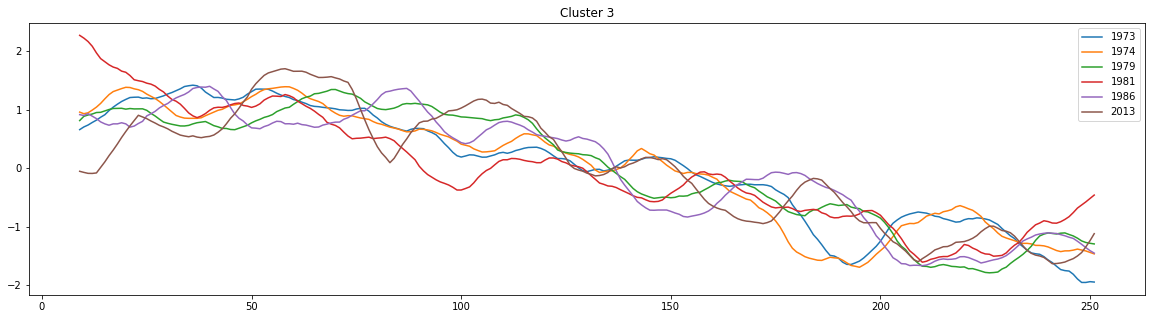

In [51]:
#cluster3
l=['1973', '1974', '1979', '1981', '1986', '2013']
for i in l:
    plot(mm1[i])
plt.title("Cluster 3")
plt.legend()

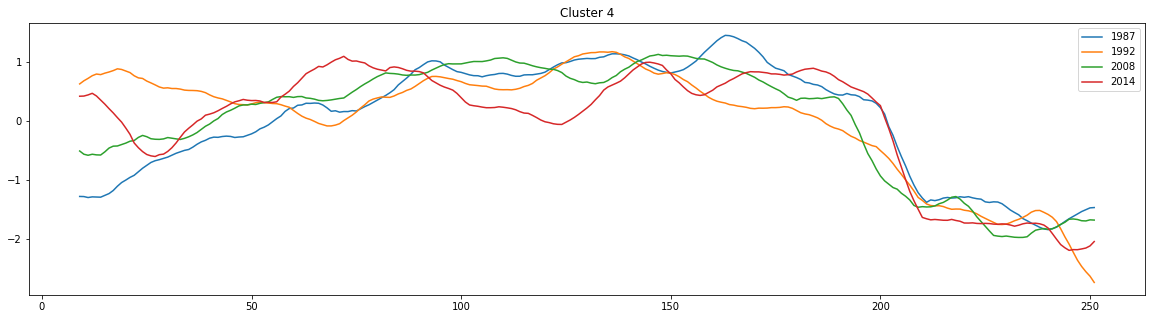

In [52]:
#cluster4
l=['1987', '1992', '2008', '2014']
for i in l:
    plot(mm1[i])
plt.title("Cluster 4")
plt.legend()

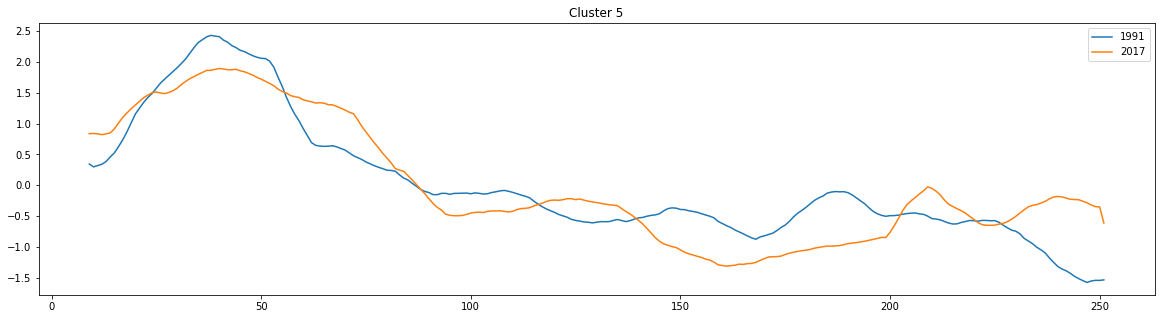

In [53]:
#cluster5
l= ['1991', '2017']
for i in l:
    plot(mm1[i])
plt.title("Cluster 5")
plt.legend()

In [94]:
def distance(x,y):
    return abs(x-y)

def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)